# Coding networks with intended degree distributions

Creating random networks with a desired degree distribution is a core task for many network experiments. There are essentially two classes of such networks:

1. Those for which there are known special-purpose algorithms that create networks with the given degree distribution
2. Those for which there is no such algorithm, and we need to create an network from a description of the degree distribution

In this notebook we'll explore how to create instances of both classes of network: the ER and BA networks in the first class, and a powerlaw-with-cutoff network in the second class.

In [117]:
# maths
from numpy import exp, linspace
from numpy.random import default_rng
from mpmath import polylog as Li
from scipy.special import zeta

# networks
import networkx
from itertools import combinations

# plotting
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'png'
matplotlib.rcParams['font.size'] = 10
import matplotlib.pyplot as plt

## Poisson (ER) networks

The Poisson-distributed or ER networks are perhaps the most influential and common ensemble in network science, and are exceptionally well-studied. It's not surprising that there's an algorithm known that creates them.

There are some mathematical facts we need to know first. An ER network is constructed from a number of nodes $N$ and  a desired mean degree $\langle k \rangle$. It turns out that the network will contain a fraction $\phi$ of the maximum number of possible edges in the network: remember this is given by $M = N (N - 1)$. The value of $\phi$ is related to $N$ and $\langle k \rangle$ according to 

$$
\langle k \rangle = N \phi
$$

and is referred to as the *occupation probability* of an edge: the probability that a possible edge will be retained into the final network

Given this, an ER network can be constructed by the following procedure:

1. Create an network of $N$ nodes and no edges
2. For each pair of of nodes, occupy the edge (that is, add it to the network) with probability $\phi$

That's it!

In [80]:
def makeER(N, phi):
    '''Percolate a network of N nodes, where each possible
    edge appears with probability phi.
    
    :param N: the number of nodes
    :param phi: the occupation probability
    :returns: a network'''
    
    # create the network with no edges
    g = networkx.Graph()
    for n in range(N):
        g.add_node(n)
        
    # wire-up the edges
    rng = default_rng()
    for e in combinations(g.nodes(), 2):
        if rng.random() <= phi:
            # e is a pair of nodes, so add an edge between them
            g.add_edge(e[0], e[1])
            
    return g

We can use this function to create an ER network with a known size and occupation probability.

In [81]:
N = int(1e4)
phi = 0.002
g_er = makeER(N, phi)

The mean degree is easily extracted, ands we could of course have targetted a desired mean degree instead.

In [4]:
kmean_er = N * phi

If we now plot the degree distribution of the network we constructed, we'll expect to see a discrete bell curve with a peak at the mean degree.

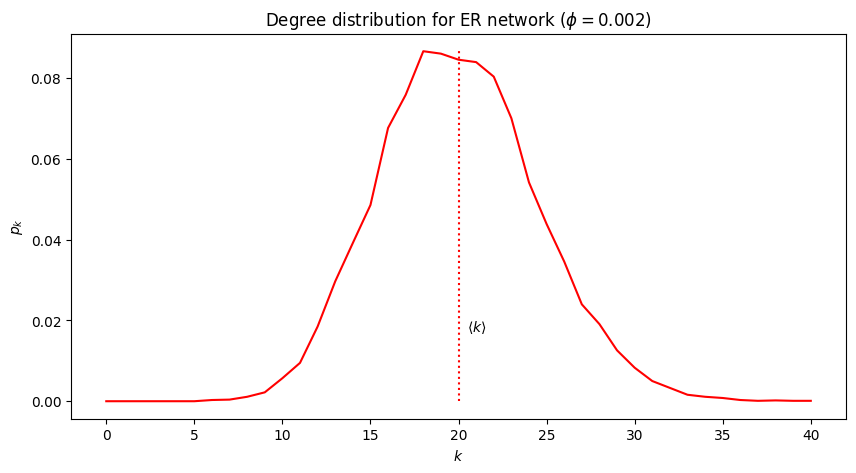

In [33]:
fig = plt.figure(figsize=(10, 5))
ax = plt.gca()

# extract the degree distribtuion histogram
degs = [d for (_, d) in list(g_er.degree())]
kmin, kmax = min(degs), max(degs)
h = [ 0 ] * (kmax + 1)
for d in degs:
    h[d] += 1
p_er = [nk / N for nk in h]

# plot the values
ax.plot(range(kmax + 1), p_er, 'r-')

# plot the expected mean degree
ax.plot([kmean_er, kmean_er], [0, max(p_er)], color='red', linestyle='dotted')
ax.annotate('$\\langle k \\rangle$', [kmean_er, min(p_er)],
            [kmean_er + 0.5, (max(p_er) * 0.2)])
                        
# set title and axis limits
ax.set_title(f'Degree distribution for ER network ($\\phi = {phi}$)')
ax.set_xlabel('$k$')
ax.set_ylabel('$p_k$')
plt.show()

That's a good fit, which gives confidence that we have the network topology we intended.

## Poisson networks with `networkx`

Actually, there's an even better way to construct ER networks in Python. Since they're the workhorses of network science, it's unsurprising that `networkx` has a function built-in to construct them. (In fact, it has two.)

In [10]:
g_nx = networkx.fast_gnp_random_graph(N, phi)

Plotting the degree distribution again:

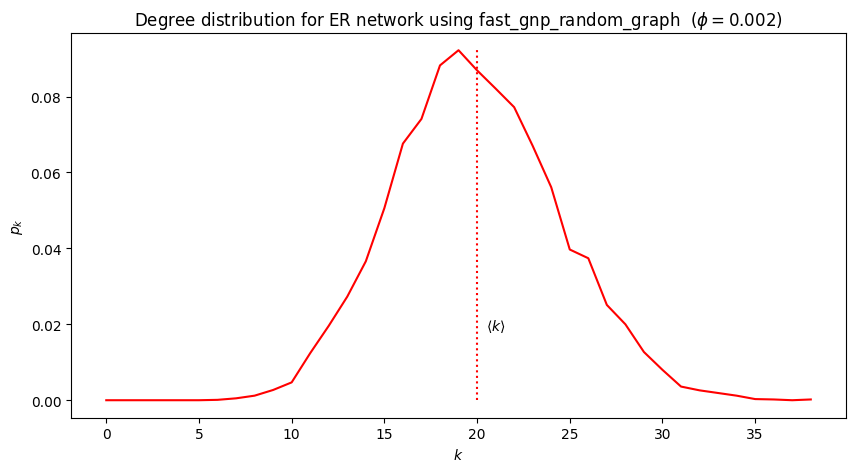

In [34]:
fig = plt.figure(figsize=(10, 5))
ax = plt.gca()

# extract the degree distribtuion histogram
degs = [d for (_, d) in list(g_nx.degree())]
kmin, kmax = min(degs), max(degs)
h = [ 0 ] * (kmax + 1)
for d in degs:
    h[d] += 1
p_nx = [nk / N for nk in h]

# plot the values
ax.plot(range(kmax + 1), p_nx, 'r-')

# plot the expected mean degree
ax.plot([kmean_er, kmean_er], [0, max(p_nx)], color='red', linestyle='dotted')
ax.annotate('$\\langle k \\rangle$', [kmean_er, min(p_nx)],
            [kmean_er + 0.5, (max(p_nx) * 0.2)])
                        
 # set title and axis limits
ax.set_title(f'Degree distribution for ER network using fast_gnp_random_graph  ($\\phi = {phi}$)')
ax.set_xlabel('$k$')
ax.set_ylabel('$p_k$')
plt.show()

If you compared the two runs you'll see that `fast_gnp_random_graph` lives up to its name: it's a *lot* faster than the version we wrote. This is because it makes use of several optimisations to reduce the number of random numbers it needs to generate, which reduces run-times considerably.

## BA networks

Let's now explore another network, the Barab&aacute;si-Albert or BA network. This is almost as famous as the ER network, being used as a model for the internet and the World Wide Web (amongst other applications).

The BA network comes from an idea called *preferential attachment*. This observation is easiest to understand in relation to the web. Let a node be a page. When a new page is added it needs to be linked to other pages. Most people adding a page will want to link it to pages that already have a lot of links, since those are clearly (by some measure) the more popular and "important" pages. So the new pages "prefer" to be attached to pages that already have a lot of other pages attached to them.

The actual BA procedure is an abstraction of this idea. We start with a small network and add nodes progressively. Each node gets a fixed number $m$ of edges when it is added, which are connected to other nodes in the network chosen in proportion to their degrees: high-degree nodes are more likely to attract new links. We continue adding nodes and edges until the network has $N$ nodes.

Barab&aacute;si and Albert demonstrated that this algorithm gives rise to a powerlaw degree distribution. We can easily check this, again by using a built-in `networkx` function, `barabasi_albert_graph`, to create the network.

In [13]:
m = 3
g_ba = networkx.barabasi_albert_graph(N, m)

We can then plot the degree distribution and see whether it follows the powerlaw scheme.

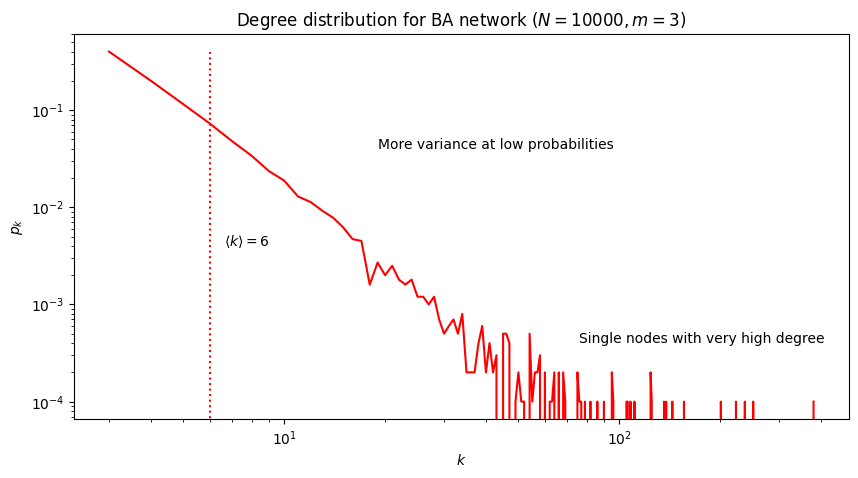

In [129]:
fig = plt.figure(figsize=(10, 5))
ax = plt.gca()

# extract the degree distribtuion histogram
degs = [d for (_, d) in list(g_ba.degree())]
kmin, kmax = min(degs), max(degs)
h = [ 0 ] * (kmax + 1)
for d in degs:
    h[d] += 1
p_ba = [nk / N for nk in h]

# plot the values
ax.plot(range(m, kmax + 1), p_ba[m:], 'r-')                        

# plot the computed mean degree
kmean_ba = sum([h[d] * d for d in range(len(h))]) / N
ax.plot([kmean_ba, kmean_ba], [min(p_ba), max(p_ba)], color='red', linestyle='dotted')
ax.annotate(f'$\\langle k \\rangle = {kmean_ba:.0f}$', [kmean_ba, max(p_ba)],
            [kmean_ba * 1.1, max(p_ba) / 100])
ax.annotate('Single nodes with very high degree', [kmax, max(p_ba)],
            [kmax * 0.2, max(p_ba) / 1000])
ax.annotate('More variance at low probabilities', [kmean_ba, max(p_ba)],
            [kmax * 0.05, max(p_ba) / 10])

 # set title and axis limits
ax.set_title(f'Degree distribution for BA network ($N = {N}, m = {m}$)')
ax.set_xlabel('$k$')
ax.set_ylabel('$p_k$')
ax.loglog()
plt.show()

The distribution is plotted on a log-log scale, where a powerlaw should appear as a straight line &ndash; and it does, suggesting that we have indeed got the right distribution.

There are a couple of things to notice. Firstly, the line is smooth for high probabilities but gets ragged as the probabilities get smaller. This is because small stochastic variations in degree &ndash; we just happen to create two rather than three nodes with a given degree, for example &ndash; have an outsized impact when there are only a very few nodes with that degree (*i.e.*, a low probability). By contrast, these variations are drowned-out when there are lots of nmodes with the given degree (*i.e.*, high probabilities).

Secondly, the small spikes at the right of the plot show that there are a small number of nodes (maybe one or two) with very high degree. That didn't happen with the ER network, where the distribtuion stayed close to the mean; but in the powerlaw distribution there can be nodes with degrees reallt far from the mean. These are the high-degree "hubs" that connect to large numbers of nodes (several hundred!), even though the computed mean degree of the network is small.

## Arbitrary topologies: The configuration model

Finally let's consider the case of networks where we know the degree distribution, but we don't have a special-purpose algorithm that can create networks with that distribution. It could be because the distribution is arbitrary, maybe measured in the real world; it could be that we only have a probability distribution.

There is a general-purpose algorithm designed to address these sitruations: the *configuration model*.

1. Create a list of *N* numbers drawn from the probability density function describing the degree distribution. These numbers represent the *edge stubs* of nodes &ndash; the points to which edges can be attached to connect them to other nodes
2. Make sure the number of edge stubs is even (so they can all be attached) by tweaking the numbers
3. Create a network with $N$ nodes and no edges
4. Choose pairs of nodes at random. If they still have edge stubs, connect them
5. Continue until all stubs have been connected

`networkx` unsurprisingly has an implementation of the configuration model &ndash; but we still need to create the list of degrees.

In [63]:
def generateFrom(N, p, maxdeg=100):
    '''Construct a network from a degree distribution probability density function.
    
    :param N: the number of nodes
    :param p: the probability density function
    :param maxdeg: (optional) the maximum degree of nodes considered (defaults to 100)
    :returns: a network'''
    
    # create the stubs
    rng = default_rng()
    ns = []
    t = 0
    for i in range(N):
        while True:
            # draw a random degree
            k = rng.integers(1, maxdeg)
            
            # do we include a node with this degree?
            if rng.random() < p(k):
                # yes, add it to the sequence; otherwise,
                # draw again
                ns.append(k)
                t += k
                break

    # the final sequence of degrees has to sum to an even
    # number, as each edge has two endpoints
    # if the sequence is odd, remove an element and draw
    # another from the distribution, repeating until the
    # overall sequence is even
    while t % 2 != 0:
        # pick a node at random
        i = rng.integers(0, len(ns) - 1)

        # remove it from the sequence and from the total
        t -= ns[i]
        del ns[i]
            
        # choose a new node to replace the one we removed
        while True:
            # draw a new degree from the distribution
            k = rng.integers(1, maxdeg)
            
            # do we include a node with this degree?
            if rng.random() < p(k):
                # yes, add it to the sequence; otherwise,
                # draw again
                ns.append(k)
                t += k
                break

    # populate the network using the configuration
    # model with the given degree distribution
    g = networkx.configuration_model(ns,
                                     create_using=networkx.Graph())
    return g

We then need a probability density function. We will use a powerlaw-with-cutoff distribution with exponent $\alpha$ and cutoff $\kappa$. The degree distribtuion is then described by

$$
p_k \propto k^{-\alpha} \, e^{-\kappa / k}
$$

This is a proportionality, of course: to get a valid probability density function we need to find the normalising constant. Fortunately this is known and uses the [polylogarithm special function](https://en.wikipedia.org/wiki/Polylogarithm), which isn't built-in to `numpy` but exists in another library, `mpmath`.

In [111]:
def makePowerlawWithCutoff(alpha, cutoff):
    '''Create a discrete probability density function for a
    powerlaw-with-cutoff distribution.
    
    :param alpha: the exponent
    :param cutoff: the cutoff
    :returns: the probability density function'''
    
    # the normnalising constant for these distributions
    C = 1.0 / Li(alpha, exp(-1.0 / cutoff))
    
    def p(k):
        '''Return the probability of finding a node of degree k.
        
        :param k: the degree
        :returns: the probability'''
        return (pow((k + 0.0), -alpha) * exp(-(k + 0.0) / cutoff)) * C
    
    return p

We can then generate our network.

In [114]:
alpha = 2
cutoff = 10

g_plc = generateFrom(N, makePowerlawWithCutoff(alpha, cutoff))

Plotting its degree distribution gives:

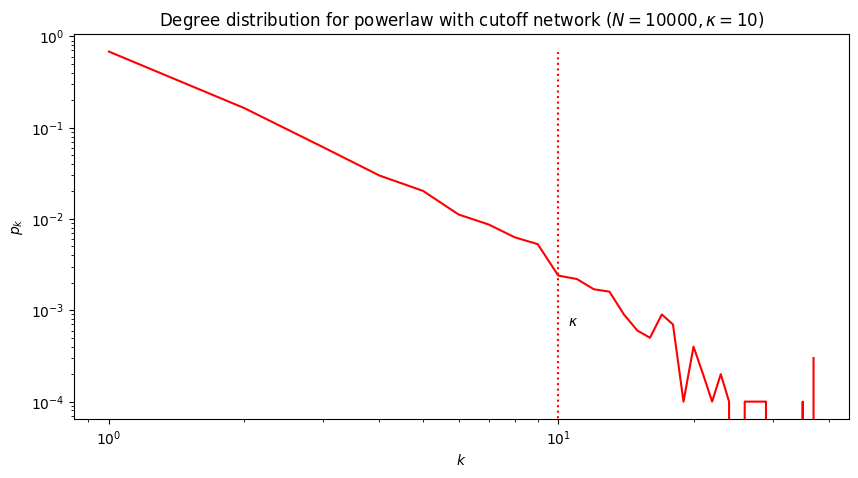

In [127]:
fig = plt.figure(figsize=(10, 5))
ax = plt.gca()

# extract the degree distribtuion histogram
degs = [d for (_, d) in list(g_plc.degree())]
kmin, kmax = min(degs), max(degs)
h = [ 0 ] * (kmax + 1)
for d in degs:
    h[d] += 1
p_plc = [nk / N for nk in h]

# plot the values
ax.plot(range(kmin, kmax + 1), p_plc[kmin:], 'r-')                        

ax.plot([cutoff, cutoff], [min(p_plc), max(p_plc)],
        color='red', linestyle='dotted')
ax.annotate('$\\kappa$', [cutoff, max(p_plc)],
            [cutoff * 1.05, max(p_plc) / 1000])

# set title and axis limits
ax.set_title(f'Degree distribution for powerlaw with cutoff network ($N = {N}, \\kappa = {cutoff}$)')
ax.set_xlabel('$k$')
ax.set_ylabel('$p_k$')
ax.loglog()
plt.show()

Again we have the straight line of a powerlaw distribution &ndash; but after the cutoff the probabilities drop-off rapidly, leading to only a small number of higher-degree nodes.

## The impact of cutoff

It perhaps isn't clear what exactly the difference is between powerlaw distributions, with and without a cutoff. There is inevitably noise in the plots above, as they're derived from real networks generated by stochastic processes. 

We can clarify things by plotting the distributions directly from their probability density functions. We already have one for the powerlaw-with-cutoff: we can define a similar one for the pure powerlaw. Again we know the proportional relationship but need a normalising constant to make it into a valid probability distribution (all the probabilities sum to 1); and again this value is known, and again uses a special function, this time the [Hurwitz zeta function](https://en.wikipedia.org/wiki/Hurwitz_zeta_function) available in `scipy`.

In [113]:
def makePowerlaw(alpha):
    '''Create a model function for a powerlaw distribution.

    :param alpha: the exponent of the distribution
    :returns: a model function'''
    
    # the normalising constant
    C = 1.0 / zeta(alpha, 1)

    def p(k):
        '''Return the probability of finding a node of degree k.
        
        :param k: the degree
        :returns: the probability'''
        return C * pow((k + 0.0), -alpha)
    
    return p

We can now plot both distributions &ndash; cleanly this time, since we have no experimental error to worry about.

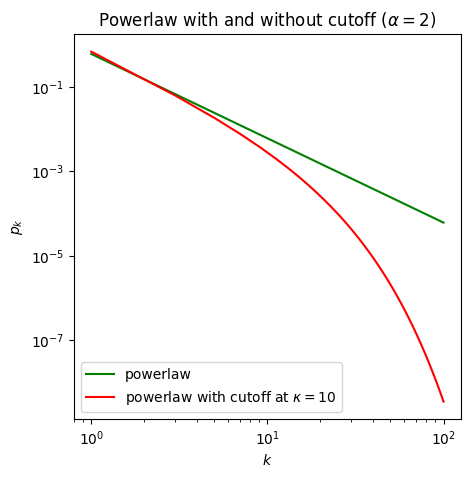

In [126]:
fig = plt.figure(figsize=(5, 5))
ax = plt.gca()

xs = linspace(1, 100)
powerlaw = makePowerlaw(alpha)
powerlaw_cutoff = makePowerlawWithCutoff(alpha, cutoff)

plt.plot(xs, [powerlaw(x) for x in xs], 'g-', label='powerlaw')
plt.plot(xs, [powerlaw_cutoff(x) for x in xs], 'r-',
         label=f'powerlaw with cutoff at $\\kappa = {cutoff}$')

ax.set_title(f'Powerlaw with and without cutoff ($\\alpha = {alpha}$)')
ax.set_xlabel('$k$')
ax.set_ylabel('$p_k$')
ax.loglog()
ax.legend(loc='lower left')
plt.show()

When we have a cutoff, look at how quickly the probability ofn high-degree nodes drops off compared to the pure powerlaw: we're about a thousand times less likely to encounter a node of degree 100.